<a href="https://colab.research.google.com/github/GustavoDarmont/Projeto-de-Machine-Learning/blob/main/MachineLearning_2025_GustavoDarmont.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FGV EPGE - Escola de Pós-Graduação em Economia
---
## Graduação em Economia
### Modelo Preditivo do IBOVESPA via Análise de Sentimento de Mercado - 02/12/2025
---
#### Aluno: Gustavo Darmont de Faria Lima (gustavodarmont@gmail.com)
##### Graduando em Economia (EPGE, 2026)
---

# Apresentação:

1. Contextualização e Motivação:\
O mercado de capitais brasileiro, representado pelo Índice Bovespa (IBOVESPA), é reconhecido por sua alta volatilidade e sensibilidade a fatores macroeconômicos e políticos. Embora a Hipótese do Mercado Eficiente (HME) sugira que os preços refletem toda a informação disponível, a Economia Comportamental aponta que vieses humanos, muitas vezes refletidos no sentimento coletivo, introduzem ineficiências que podem ser exploradas para fins preditivos e de arbitragem.

    Este projeto propõe-se a explorar uma linha metodológica no estudo da precificação de ativos no Brasil, fazendo uso do poder do Processamento de Linguagem Natural (NLP) para quantificar o sentimento de mercado.

2. Objetivo e Metodologia:\
O objetivo central deste trabalho é construir e validar um Modelo de Machine Learning capaz de prever o comportamento direcional (subida ou queda) do IBOVESPA em D+1, utilizando o sentimento agregado de notícias como principal fator preditivo.

    A metodologia abrange quatro etapas principais:

    - Coleta e Engenharia de Features: Coletamos dados históricos de preços do IBOVESPA e um vasto corpus de notícias financeiras e macroeconômicas do portal G1, abrangendo o período referente aos últimos 5 anos (12/2020 até 12/2025).

    - Quantificação do Sentimento (NLP): Utilizamos o modelo de Deep Learning pré-treinado FinBERT-PT-BR criado por Lucas Leme (específico para textos financeiros em Português) para classificar o sentimento de cada notícia e agregá-lo em métricas diárias, como Sentimento Ponderado Médio e Volume de Notícias.

    - Desagregação Fatorial (PCA): Aplicamos a análise de componentes principais (PCA) nas séries temporais de sentimento por palavras-chave (ex: selic, fiscal, petrobras) para descorrelacionar as variáveis e extrair Fatores Latentes (como Fator de Risco Fiscal e Fator de Risco Externo).

    - Modelagem Preditiva: O modelo final é uma Regressão Regularizada (Ridge e Lasso), treinada com validação cruzada temporal (TimeSeriesSplit), utilizando os fatores extraídos pelo PCA e indicadores técnicos (como a volatilidade do índice) para prever o retorno do IBOVESPA em D+1.


3. Contribuições Esperadas:\
As principais contribuições deste estudo são:

    - Validação do Fator Sentimento no Brasil: Avaliar empiricamente se o sentimento extraído de fontes noticiosas brasileiras possui poder preditivo (Alpha), superando o índice de mercad (Benchmarking Índice IBOVESPA).

    - Identificação de Fatores de Risco: Oferecer uma interpretação econômica aos componentes principais, permitindo correlacionar o desempenho do IBOVESPA com vetores de risco noticiosos específicos (ex: Qual o peso do "Fator China" versus o "Fator Juros Domésticos" na volatilidade diária?).

    - Proposta de Estratégia de Investimento: Demonstrar, por meio de simulação de Curva de Capital (Equity Curve), se uma estratégia de investimento baseada no modelo de sentimento (Long/Short) seria capaz de gerar retornos consistentes e superiores ao benchmark (Buy & Hold).

# Introdução

Para o desenvolvimento deste modelo preditivo, foram utilizadas duas bases de dados primárias: os dados históricos de preços e volatilidade do IBOVESPA, obtidos através da API do Yahoo Finance, e um corpus abrangente de notícias de caráter econômico e/ou político extraídas do portal G1 via compilador de notícias sitemap.xml disponibilizado pelo próprio portal.

A implementação técnica foi realizada em Python, empregando um conjunto robusto de bibliotecas para cobrir o ciclo de vida dos dados:

- Coleta de Dados: Utilizamos yfinance para dados de mercado e o conjunto requests, BeautifulSoup e selenium para a raspagem (web scraping) e estruturação das notícias web.

- Manipulação e Processamento: As bibliotecas pandas e numpy foram fundamentais para a estruturação dos dataframes, tratamento de séries temporais e operações numéricas, com o auxílio de datetime para gestão temporal e tqdm para monitoramento de processos longos.

- Análise Exploratória e Visualização: Para a compreensão visual dos dados e correlações, empregamos matplotlib e seaborn.

- Modelagem e Machine Learning: A biblioteca scikit-learn (sklearn) formou a base da modelagem estatística. Foram utilizados módulos específicos para pré-processamento (StandardScaler), redução de dimensionalidade (PCA), regressão linear e regularizada (LinearRegression, RidgeCV, LassoCV), além de métricas de avaliação (mean_squared_error, r2_score) e validação cruzada apropriada para séries temporais (TimeSeriesSplit).

Adicionalmente, para assegurar a eficiência operacional e a persistência dos dados, o projeto foi integrado ao ambiente em nuvem do Google Drive. Essa arquitetura permitiu o armazenamento incremental e a recuperação ágil das bases de dados construídas, eliminando a redundância na execução das etapas de coleta e raspagem (web scraping), processos que demandam alto custo computacional e temporal.

In [2]:
# AJUSTE PARA O GITHUB
import nbformat
from IPython.display import display, Javascript

notebook_path = "https://colab.research.google.com/drive/1LTIpeIWj0ZtgkEBRBVWhmVnhXnnSkvJr?usp=drive_link

def remove_widgets_metadata(notebook_path):
    try:
        with open(notebook_path, 'r', encoding='utf-8') as f:
            notebook = nbformat.read(f, as_version=4)

        if 'widgets' in notebook.metadata:
            del notebook.metadata['widgets']
            print("Removed 'metadata.widgets' from the notebook.")
        else:
            print("'metadata.widgets' not found in the notebook.")

        with open(notebook_path, 'w', encoding='utf-8') as f:
            nbformat.write(notebook, f)
        print(f"Notebook saved successfully to {notebook_path}")

    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
## CÉLULA 0: SUPORTE DE INSTALAÇÃO DOS PACOTES

import subprocess
import sys

required_packages = [
    'yfinance', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'requests',
    'beautifulsoup4', 'tqdm', 'selenium', 'webdriver-manager'
]

for package in required_packages:
    try:
        # Tenta importar o pacote para verificar se já está instalado
        __import__(package.replace('-', '_')) # Replace hyphen for valid module name
        print(f"Requirement already satisfied: {package}")
    except ImportError:
        # Se o pacote não puder ser importado, tenta instalá-lo
        print(f"Installing missing package: {package}")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print(f"Successfully installed {package}")


Installing missing package: beautifulsoup4


In [ ]:
## CÉLULA 1: SETUP DO PROJETO

# Importação das Bibliotecas Necessárias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import os
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
from datetime import datetime, timedelta
from urllib.parse import quote
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit

# Cria a pasta para armazenamento dos arquivos do projeto
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Projeto_FGV'

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    print(f"Pasta criada: {base_dir}")

# Desenvolvimento

### Descrição das Bases de Dados

O desenvolvimento deste estudo fundamenta-se na integração e processamento de duas bases de dados distintas — uma financeira e outra textual — que foram consolidadas para viabilizar a modelagem preditiva proposta.

#### 1. Base de Dados Financeira (IBOVESPA)
A primeira base de dados fornece a variável alvo do estudo, bem como indicadores técnicos auxiliares essenciais para a análise de séries temporais. Os dados foram extraídos da API do Yahoo Finance (`yfinance`), acessada de forma automatizada via biblioteca Python. O recorte temporal abrange o período de 1º de dezembro de 2020 até a data presente (2 de dezembro de 2025), com granularidade diária restrita aos dias de pregão, totalizando 1.227 observações.

Em termos de características (*features*), a base original é composta pelas cotações diárias de Abertura, Máxima, Mínima e Fechamento (*Close*), além do Volume de negociações. Para o enriquecimento da modelagem, realizou-se um tratamento prévio que incluiu o cálculo de variáveis derivadas, especificamente o retorno diário percentual e a volatilidade móvel calculada sobre uma janela de 21 dias, além do saneamento de dias sem negociação (*missings*).

#### 2. Base de Dados Textual (Notícias)
A segunda base de dados provê as informações não estruturadas necessárias para a extração de sentimento, que atuam como variáveis explicativas latentes no modelo. A fonte primária dos dados é o portal de notícias G1, especificamente as seções de Economia, Política, Agronegócios e Mundo. A coleta foi realizada por meio de um algoritmo de *Web Scraping* customizado, utilizando as bibliotecas `requests` e `BeautifulSoup` para a varredura sistemática de *sitemaps* XML e subsequente extração do conteúdo HTML.

Para garantir a relevância econômica, aplicou-se um filtro duplo de conteúdo restrito a notícias das seções supracitadas e contendo uma das 18 palavras-chave estratégicas previamente definidas, tais como "Selic", "Fiscal", "Petrobras" e "Inflação". O *dataset* resultante contém mais de 50 mil artigos, cujas variáveis brutas incluem o título da notícia, a data de publicação e o corpo do texto. Cada título foi submetido a um processamento de Linguagem Natural (NLP) utilizando o modelo `FinBERT-PT-BR`, gerando como *output* um *score* numérico de sentimento (variando de -1 a 1) e um rótulo de classificação categórica (Positivo, Neutro ou Negativo).

#### 3. Dataset Final de Modelagem (Matriz de Features)
Para o treinamento dos algoritmos de Machine Learning, as duas bases supracitadas foram fundidas em um único *dataframe* estruturado temporalmente, onde a unidade de observação é o dia (*time-step*). Um aspecto crítico desta consolidação foi o alinhamento temporal, no qual o sentimento extraído de notícias publicadas em dias não úteis (finais de semana e feriados) foi matematicamente agregado ao dia útil subsequente, visando capturar o acúmulo de informações que impactam a abertura do mercado.

A matriz final de variáveis explicativas é composta por indicadores de sentimento agregado, como o Sentimento Médio Ponderado diário, o Índice de Polaridade e o Volume de Notícias (suavizado por média móvel de 3 dias). Adicionalmente, foram incluídos fatores latentes extraídos via Análise de Componentes Principais (PCA) das séries de sentimento por tema, bem como indicadores técnicos financeiros, como o retorno defasado e a volatilidade histórica. A variável alvo (y) a ser prevista é o retorno do IBOVESPA em $D+1$ (dia seguinte), permitindo a modelagem tanto como um problema de regressão (valor contínuo) quanto de classificação binária (direção do mercado).

/tmp/ipython-input-2413125587.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ibov_df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Baixando dados históricos do IBOVESPA (^BVSP) de 2020-12-01 a 2025-12-03...
Download concluído com sucesso!

Primeiras 5 linhas do DataFrame com retorno e volatilidade:
Price          Close      High       Low      Open    Volume retorno_diario  \
Ticker         ^BVSP     ^BVSP     ^BVSP     ^BVSP     ^BVSP                  
Date                                                                          
2021-01-05  119223.0  119790.0  116756.0  118835.0   9257100       0.560907   
2021-01-06  119851.0  120924.0  118917.0  119377.0  11638200       0.526744   
2021-01-07  121956.0  121983.0  119101.0  119103.0  11774800       1.756347   
2021-01-08  125077.0  125324.0  122386.0  122387.0  11085800       2.559120   
2021-01-11  122807.0  125075.0  122506.0  125075.0   9537600      -1.814882   

Price      volatilidade_21d  
Ticker                       
Date                         
2021-01-05         0.818777  
2021-01-06         0.819641  
2021-01-07         0.866104  
2021-01-08        

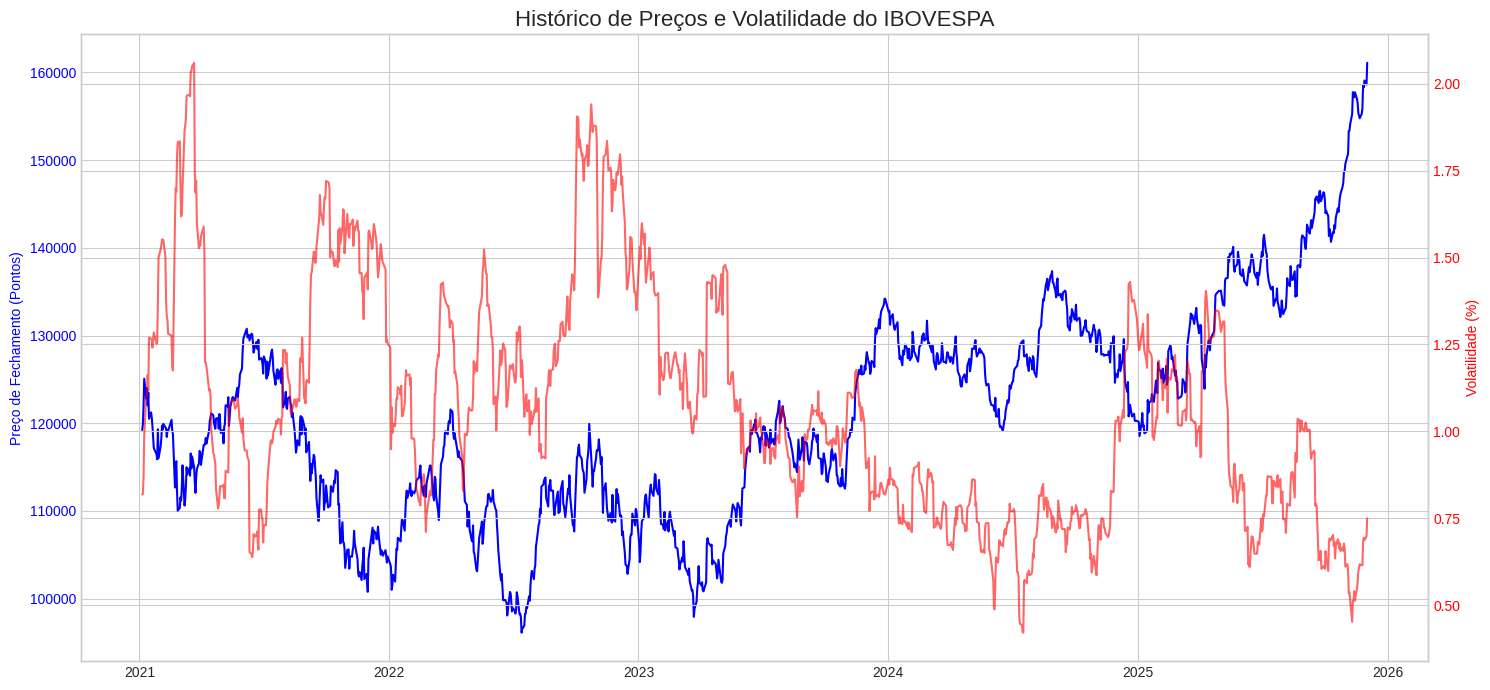

In [ ]:
## CÉLULA 2: COLETA DE DADOS FINANCEIROS
# Define o ticker para o IBOVESPA
ticker = '^BVSP'

# Define o período dos dados
start_date = '2020-12-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print(f"Baixando dados históricos do IBOVESPA ({ticker}) de {start_date} a {end_date}...")

# Baixa os dados usando yfinance
ibov_df = yf.download(ticker, start=start_date, end=end_date)

if not ibov_df.empty:
    print("Download concluído com sucesso!")

    # Calcular o retorno diário sobre o preço de fechamento ('Adj Close')
    # Ajustado para acessar a coluna 'Price' sob o índice multinível
    ibov_df['retorno_diario'] = ibov_df[('Close', ticker)].pct_change() * 100

    # Calcular a volatilidade móvel de 21 dias (aproximadamente 1 mês de pregões)
    ibov_df['volatilidade_21d'] = ibov_df['retorno_diario'].rolling(window=21).std()

    # Remover a primeira linha que terá valores NaN devido aos cálculos
    ibov_df.dropna(inplace=True)

    print("\nPrimeiras 5 linhas do DataFrame com retorno e volatilidade:")
    print(ibov_df.head())
    print(f"\nO DataFrame possui {len(ibov_df)} dias de pregão")

    # Plotar o preço de fechamento do IBOVESPA
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(15, 7))

    # Ajustado para plotar a coluna 'Price' sob o índice multinível
    ax1.plot(ibov_df[('Close', ticker)], label='Preço de Fechamento IBOV', color='blue')
    ax1.set_title('Histórico de Preços e Volatilidade do IBOVESPA', fontsize=16)
    ax1.set_ylabel('Preço de Fechamento (Pontos)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Criar um segundo eixo Y para a volatilidade
    ax2 = ax1.twinx()
    ax2.plot(ibov_df['volatilidade_21d'], label='Volatilidade Móvel (21 dias)', color='red', alpha=0.6)
    ax2.set_ylabel('Volatilidade (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.tight_layout()
    plt.show()

else:
    print("Falha ao baixar os dados. Verifique o ticker ou sua conexão com a internet.")

In [ ]:
## CÉLULA 3: ANÁLISE DO SITEMAP G1
# URL do sitemap principal do G1
sitemap_index_url = 'https://g1.globo.com/sitemap/g1/sitemap.xml'
print(f"Acessando o sitemap principal: {sitemap_index_url}\n")

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

try:
    response = requests.get(sitemap_index_url, headers=headers)

    # Verifica se a requisição foi bem-sucedida
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'xml')

        # Em um sitemap index, os links para outros sitemaps estão dentro de tags <loc>
        sitemap_urls = [loc.text for loc in soup.find_all('loc')]

        print(f"Encontrados {len(sitemap_urls)} links para sitemaps secundários.")

        if sitemap_urls:
            print("Exibindo os 5 primeiros links encontrados:")
            for url in sitemap_urls[:5]:
                print(url)

            print("\nExibindo os 5 últimos links encontrados:")
            for url in sitemap_urls[-5:]:
                print(url)

            # Colocamos esses links em um DataFrame para facilitar a visualização
            df_sitemaps = pd.DataFrame(sitemap_urls, columns=['Sitemap_URL'])

    else:
        print(f"Falha ao acessar o sitemap. Código de status: {response.status_code}")

except requests.exceptions.RequestException as e:
    print(f"Ocorreu um erro de conexão: {e}")

Acessando o sitemap principal: https://g1.globo.com/sitemap/g1/sitemap.xml

Encontrados 8805 links para sitemaps secundários.
Exibindo os 5 primeiros links encontrados:
https://g1.globo.com/sitemap/g1/2025/12/03_1.xml
https://g1.globo.com/sitemap/g1/2025/12/02_1.xml
https://g1.globo.com/sitemap/g1/2025/12/01_1.xml
https://g1.globo.com/sitemap/g1/2025/11/30_1.xml
https://g1.globo.com/sitemap/g1/2025/11/29_1.xml

Exibindo os 5 últimos links encontrados:
https://g1.globo.com/sitemap/g1/2003/02/23_1.xml
https://g1.globo.com/sitemap/g1/2003/02/16_1.xml
https://g1.globo.com/sitemap/g1/2003/02/02_1.xml
https://g1.globo.com/sitemap/g1/2003/01/19_1.xml
https://g1.globo.com/sitemap/g1/2003/01/05_1.xml


In [ ]:
## CÉLULA 4: EXTRAÇÃO DAS NOTÍCIAS DO G1
def get_secondary_sitemaps(sitemap_index_url):
    "Acessa o sitemap principal e retorna a lista de sitemaps secundários."
    print(f"Acessando o sitemap principal: {sitemap_index_url}")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    try:
        response = requests.get(sitemap_index_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'xml')
        sitemap_urls = [loc.text for loc in soup.find_all('loc')]
        return sitemap_urls
    except requests.exceptions.RequestException as e:
        print(f"Ocorreu um erro de conexão: {e}")
        return []

def extract_news_urls_from_sitemap(sitemap_url):
    "Acessa um sitemap secundário e extrai as URLs dos artigos de notícia."
    print(f"--> Analisando sitemap secundário: {sitemap_url}")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    try:
        response = requests.get(sitemap_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'xml')
        article_urls = [loc.text for loc in soup.find_all('loc')]
        return article_urls
    except requests.exceptions.RequestException as e:
        print(f"Ocorreu um erro ao acessar {sitemap_url}: {e}")
        return []

# LÓGICA PRINCIPAL DE COLETA DE NOTÍCIAS
output_path = os.path.join(base_dir, 'urls_para_coleta.csv')

# 1. Lógica de retomada: verificar o que já foi coletado
sitemaps_ja_processados = set()
if os.path.exists(output_path):
    try:
        df_existente = pd.read_csv(output_path)
        # Verificamos quais sitemaps de origem já estão no arquivo
        if 'sitemap_source' in df_existente.columns:
            sitemaps_ja_processados = set(df_existente['sitemap_source'].unique())
            print(f"Arquivo de progresso encontrado. {len(sitemaps_ja_processados)} sitemaps já processados serão pulados.")
    except pd.errors.EmptyDataError:
        pass

# 2. Obter lista de sitemaps
sitemap_index_url = 'https://g1.globo.com/sitemap/g1/sitemap.xml'
all_secondary_sitemaps = get_secondary_sitemaps(sitemap_index_url)

if all_secondary_sitemaps:
    start_date = pd.to_datetime('2020-12-01')
    end_date = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))

    sitemaps_a_processar = []
    for s_url in all_secondary_sitemaps:
        try:
            parts = s_url.split('/')
            year, month = int(parts[-3]), int(parts[-2])
            sitemap_date = pd.to_datetime(f'{year}-{month}-01')
            if start_date <= sitemap_date <= end_date:
                sitemaps_a_processar.append(s_url)
        except:
            continue

    print(f"\nEncontrados {len(sitemaps_a_processar)} sitemaps no período.")

    # Filtros
    editorias_relevantes = ['/economia/', '/politica/', '/agronegocios/', '/mundo/']
    palavras_chave_relevantes = ['ibovespa', 'bolsa', 'selic', 'copom', 'inflação', 'pib', 'juros', 'fiscal', 'governo', 'congresso', 'reforma', 'fed', 'eua', 'china', 'petróleo', 'petrobras', 'vale', 'itaú']

    # Batch Saving
    urls_buffer = [] # Lista temporária para acumular dados
    BATCH_SIZE = 50  # Salvar a cada 50 sitemaps

    for i, sitemap_url in enumerate(sitemaps_a_processar):

        if sitemap_url in sitemaps_ja_processados:
            continue
        print(f"Processando sitemap {i+1}/{len(sitemaps_a_processar)}: {sitemap_url}")

        # Extrai URLs
        article_urls = extract_news_urls_from_sitemap(sitemap_url)

        if article_urls:
            # Filtra em memória
            relevant = [
                url for url in article_urls
                if any(ed in url for ed in editorias_relevantes)
                and any(kw in url for kw in palavras_chave_relevantes)
            ]

            # Adiciona ao buffer (não salva ainda)
            for url in relevant:
                urls_buffer.append({'sitemap_source': sitemap_url, 'url': url})

            print(f"--> Encontradas {len(relevant)} URLs relevantes.")

        # LÓGICA DE SALVAMENTO EM BLOCOS
        # Salva se tiver dados no buffer e atingiu 50 sitemaps ou é o último da lista
        if len(urls_buffer) > 0 and ((i + 1) % BATCH_SIZE == 0 or (i + 1) == len(sitemaps_a_processar)):

            print(f"\n--- Salvando lote no Drive (Sitemap {i+1}/{len(sitemaps_a_processar)}) ---")
            df_batch = pd.DataFrame(urls_buffer)

            # Modo 'append' se arquivo existe, 'write' se não
            if not os.path.exists(output_path):
                df_batch.to_csv(output_path, index=False)
            else:
                df_batch.to_csv(output_path, mode='a', header=False, index=False)

            print(f"--> {len(urls_buffer)} novas URLs salvas.")
            urls_buffer = [] # Limpa o buffer para o próximo lote

        time.sleep(0.5) # Delay para não sobrecarregar o servidor

    print("\nColeta finalizada.")
else:
    print("Erro ao obter sitemaps.")

Arquivo de progresso encontrado. 4703 sitemaps já processados serão pulados.
Acessando o sitemap principal: https://g1.globo.com/sitemap/g1/sitemap.xml

Encontrados 2072 sitemaps no período.
Processando sitemap 1/2072: https://g1.globo.com/sitemap/g1/2025/12/03_1.xml
--> Analisando sitemap secundário: https://g1.globo.com/sitemap/g1/2025/12/03_1.xml
--> Encontradas 2 URLs relevantes.
Processando sitemap 382/2072: https://g1.globo.com/sitemap/g1/2024/11/17_1.xml
--> Analisando sitemap secundário: https://g1.globo.com/sitemap/g1/2024/11/17_1.xml
--> Encontradas 0 URLs relevantes.
Processando sitemap 424/2072: https://g1.globo.com/sitemap/g1/2024/10/07_2.xml
--> Analisando sitemap secundário: https://g1.globo.com/sitemap/g1/2024/10/07_2.xml
--> Encontradas 0 URLs relevantes.
Processando sitemap 425/2072: https://g1.globo.com/sitemap/g1/2024/10/07_3.xml
--> Analisando sitemap secundário: https://g1.globo.com/sitemap/g1/2024/10/07_3.xml
--> Encontradas 0 URLs relevantes.
Processando sitemap

KeyboardInterrupt: 

In [ ]:
## CÉLULA 4.1: EXIBINDO O NÚMERO DE LINHAS (NOTÍCIAS) EXTRAÍDAS
output_path = os.path.join(base_dir, 'urls_para_coleta.csv')

if os.path.exists(output_path):
    try:
        df_urls_coletadas = pd.read_csv(output_path)
        print(f"O arquivo '{output_path}' possui {len(df_urls_coletadas)} linhas.")
    except pd.errors.EmptyDataError:
        print(f"O arquivo '{output_path}' está vazio.")
else:
    print(f"O arquivo '{output_path}' não foi encontrado. Certifique-se de que a etapa de coleta de URLs foi executada e salva o arquivo.")

O arquivo '/content/drive/MyDrive/Projeto_FGV/urls_para_coleta.csv' possui 52216 linhas.


In [ ]:
## CÉLULA 5: SCRAPER DE CONTEÚDO DAS NOTÍCIAS
def scrape_article_content(url):
    """
    Visita a URL de um artigo e extrai seu título, data e corpo using requests and BeautifulSoup.
    Retorna um dicionário com os dados ou None se falhar.
    """
    print(f"--> Acessando URL: {url}")
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status() # Reporta HTTPError para respostas ruins (4xx or 5xx)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Encontrando os elementos
        # Para o G1, os seletores comuns são:
        titulo_tag = soup.find('h1', class_='content-head__title')
        titulo = titulo_tag.text.strip() if titulo_tag else 'Título não encontrado'

        data_publicacao_tag = soup.find('time', itemprop='datePublished')
        data_publicacao = data_publicacao_tag.text.strip() if data_publicacao_tag else 'Data não encontrada'

        # O corpo da notícia no G1 geralmente está em divs com a classe 'content-text__container'
        content_divs = soup.find_all('div', class_='content-text__container')
        corpo_noticia = ' '.join([div.text.strip() for div in content_divs]) if content_divs else 'Corpo da notícia não encontrado'


        return {
            'url': url,
            'titulo': titulo,
            'data_publicacao': data_publicacao,
            'corpo_noticia': corpo_noticia
        }

    except requests.exceptions.RequestException as e:
        print(f"--> Erro de requisição ao processar a URL {url}: {e}")
        return None
    except Exception as e:
        print(f"--> Erro ao processar a URL {url}: {e}")
        return None


# LÓGICA PRINCIPAL DO SCRAPER DE CONTEÚDO
# 1. Carregar a lista de URLs que o script anterior gerou
input_file = os.path.join(base_dir, 'urls_para_coleta.csv')
output_file = os.path.join(base_dir, 'noticias_conteudo_bruto.csv')

print(f"Carregando URLs do arquivo '{input_file}'...")
try:
    df_urls = pd.read_csv(input_file)
except FileNotFoundError:
    print(f"Arquivo '{input_file}' não encontrado. Execute o script de coleta de URLs primeiro.")
    df_urls = pd.DataFrame(columns=['url']) # Cria um DataFrame vazio para evitar erros futuros


# 2. Lógica de retomada: verificar o que já foi coletado
urls_ja_coletadas = set()
try:
    df_existente = pd.read_csv(output_file)
    urls_ja_coletadas = set(df_existente['url'])
    print(f"Encontrado arquivo de progresso. {len(urls_ja_coletadas)} URLs já foram coletadas e serão puladas.")
except FileNotFoundError:
    print("Nenhum arquivo de progresso encontrado. Começando do zero.")
except pd.errors.EmptyDataError:
    print("Arquivo de progresso encontrado, mas está vazio. Começando do zero.")


urls_para_coletar = [url for url in df_urls['url'] if url not in urls_ja_coletadas]
print(f"Restam {len(urls_para_coletar)} URLs para coletar.")

# 3. Iniciar o processo de scraping
if urls_para_coletar:
    print("Iniciando o scraping do conteúdo com requests e BeautifulSoup...")

    dados_coletados = []

    for i, url in enumerate(urls_para_coletar):
        print(f"Processando URL {i+1}/{len(urls_para_coletar)}: {url}")

        # Coleta o conteúdo do artigo
        article_data = scrape_article_content(url)

        if article_data:
            dados_coletados.append(article_data)

        # Lógica de salvamento progressivo: salva a cada 50 notícias (batch saving)
        if (i + 1) % 50 == 0:
            print(f"\n--- Salvando progresso: {len(dados_coletados)} novas notícias coletadas ---")
            df_progresso = pd.DataFrame(dados_coletados)

            # Se o arquivo de saída já existe, concatena. Senão, cria um novo.
            if os.path.exists(output_file):
                df_progresso.to_csv(output_file, mode='a', header=False, index=False)
            else:
                df_progresso.to_csv(output_file, index=False)

            # Limpa a lista para o próximo lote
            dados_coletados = []
            print("Progresso salvo com sucesso!\n")
        time.sleep(0.5)


    # Salva o lote final de notícias que sobraram
    if dados_coletados:
        print("\n--- Salvando lote final de notícias ---")
        df_final = pd.DataFrame(dados_coletados)
        if os.path.exists(output_file):
            df_final.to_csv(output_file, mode='a', header=False, index=False)
        else:
            df_final.to_csv(output_file, index=False)
        print("Lote final salvo com sucesso!")

    print("Scraping de conteúdo finalizado.")

else:
    print("Todas as URLs já foram processadas.")

Carregando URLs do arquivo '/content/drive/MyDrive/Projeto_FGV/urls_para_coleta.csv'...
Encontrado arquivo de progresso. 15745 URLs já foram coletadas e serão puladas.
Restam 36471 URLs para coletar.
Iniciando o scraping do conteúdo com requests e BeautifulSoup...
Processando URL 1/36471: https://g1.globo.com/politica/noticia/2022/03/16/lira-repete-bolsonaro-e-cobra-da-petrobras-revisao-do-aumento-de-precos-dos-combustiveis.ghtml
--> Acessando URL: https://g1.globo.com/politica/noticia/2022/03/16/lira-repete-bolsonaro-e-cobra-da-petrobras-revisao-do-aumento-de-precos-dos-combustiveis.ghtml
Processando URL 2/36471: https://g1.globo.com/economia/noticia/2022/03/16/banco-central-dos-eua-sobe-juros.ghtml
--> Acessando URL: https://g1.globo.com/economia/noticia/2022/03/16/banco-central-dos-eua-sobe-juros.ghtml
Processando URL 3/36471: https://g1.globo.com/politica/noticia/2022/03/16/bolsonaro-diz-que-petrobras-nao-colabora-com-nada-e-que-para-ele-poderia-ser-privatizada-hoje.ghtml
--> Acess

KeyboardInterrupt: 

In [ ]:
## CÉLULA 6: CARREGAMENTO DO MODELO DE SENTIMENTO FINBERT-PT-BR DE LUCAS LEME.
from transformers import pipeline

# O modelo 'lucas-leme/FinBERT-PT-BR' é treinado especificamente para análise de sentimento em textos financeiros em português, desenvolvido especificamente para o mercado brasileiro de ações.
model_name = "lucas-leme/FinBERT-PT-BR"

print(f"Carregando o pipeline de análise de sentimento com o modelo: {model_name}")
# Este comando baixa o modelo e o tokenizador e os prepara para uso.
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

print("Modelo carregado e pronto para uso!")

# Exemplo de teste rápido
exemplo_noticia = "Ibovespa fecha em forte alta com otimismo sobre dados de inflação."
resultado = sentiment_pipeline(exemplo_noticia)
print(f"\nTeste do modelo:\nNotícia: '{exemplo_noticia}'\nResultado: {resultado}")

Carregando o pipeline de análise de sentimento com o modelo: lucas-leme/FinBERT-PT-BR


Device set to use cpu


Modelo carregado e pronto para uso!

Teste do modelo:
Notícia: 'Ibovespa fecha em forte alta com otimismo sobre dados de inflação.'
Resultado: [{'label': 'POSITIVE', 'score': 0.8264712691307068}]


In [ ]:
## CÉLULA 7: TESTE DO MODELO

# Função de parse de data
def parse_publication_date(date_str):
    if "há" in date_str:
        return datetime.now().date()
    if "ontem" in date_str:
        return (datetime.now() - timedelta(days=1)).date()
    try:
        date_part = date_str.split(' ')[0]
        return pd.to_datetime(date_part, format='%d/%m/%Y').date()
    except (ValueError, TypeError):
        return None

# CARREGAMENTO E PREPARAÇÃO DOS DADOS
input_file = os.path.join(base_dir, 'noticias_conteudo_bruto.csv')
print(f"Carregando notícias do arquivo '{input_file}'...")

try:
    df_noticias = pd.read_csv(input_file)
    df_noticias.dropna(subset=['titulo'], inplace=True)
    df_noticias['titulo'] = df_noticias['titulo'].astype(str)

    # --- AMOSTRA PARA TESTE ---
    df_amostra = df_noticias.sample(min(20, len(df_noticias)))

    print("\nIniciando análise de sentimento na amostra...")
    titulos_amostra = df_amostra['titulo'].tolist()

    # O pipeline retorna uma lista de dicionários: [{'label': 'POSITIVE', 'score': 0.98}, ...]
    resultados_sentimento = sentiment_pipeline(titulos_amostra)

    df_amostra['sentimento_label'] = [res['label'] for res in resultados_sentimento]
    df_amostra['sentimento_score'] = [res['score'] for res in resultados_sentimento]

    # Ajustado para o output real do modelo (POSITIVE/NEGATIVE/NEUTRAL)
    sentiment_map = {
        'POSITIVE': 1,
        'NEUTRAL': 0,
        'NEGATIVE': -1
    }

    # Cria o valor base (-1, 0, 1)
    df_amostra['sentimento_valor'] = df_amostra['sentimento_label'].map(sentiment_map)

    # CRIANDO LÓGICA DE SENTIMENTO PONDERADO
    # Multiplica o valor (+1/-1) pela confiança (score).
    # Ex: Positivo (1) com 0.82 score = 0.82. Negativo (-1) com 0.90 score = -0.90.
    df_amostra['sentimento_ponderado'] = df_amostra['sentimento_valor'] * df_amostra['sentimento_score']

    df_amostra['data'] = pd.to_datetime(df_amostra['data_publicacao'].apply(parse_publication_date))
    df_amostra.dropna(subset=['sentimento_valor', 'data'], inplace=True)

    print("\nResultado da análise na amostra (com score):")
    print(df_amostra[['titulo', 'sentimento_label', 'sentimento_score', 'sentimento_ponderado']].head())

    # --- AGREGAÇÃO DIÁRIA (TESTE) ---
    df_diario_teste = df_amostra.groupby('data').agg(
        sentimento_medio=('sentimento_valor', 'mean'),      # Média simples (-1 a 1)
        sentimento_score_medio=('sentimento_ponderado', 'mean'), # Média ponderada pela confiança
        volume_noticias=('titulo', 'count')
    )

    print("\nAgregação Diária (Teste):")
    print(df_diario_teste)

except FileNotFoundError:
    print(f"Arquivo '{input_file}' não encontrado.")

Carregando notícias do arquivo '/content/drive/MyDrive/Projeto_FGV/noticias_conteudo_bruto.csv'...

Iniciando análise de sentimento na amostra...

Resultado da análise na amostra (com score):
                                                  titulo sentimento_label  \
11657  Governo Lula perde muito tempo com Bolsonaro e...         NEGATIVE   
1541   Para fortalecer acordo comercial, Trump suspen...         NEGATIVE   
3782   Segurança: em resposta a PEC do governo, senad...          NEUTRAL   
11984  FBI vasculha casa de ex-vice dos EUA atrás de ...         NEGATIVE   
9576   A família que abandonou civilização e acabou m...         NEGATIVE   

       sentimento_score  sentimento_ponderado  
11657          0.800029             -0.800029  
1541           0.827725             -0.827725  
3782           0.746661              0.000000  
11984          0.779273             -0.779273  
9576           0.826703             -0.826703  

Agregação Diária (Teste):
            sentimento_medio  

In [ ]:
## CÉLULA 8: ANÁLISE DE SENTIMENTO COMPLETA E AGREGAÇÃO DIÁRIA

input_file = os.path.join(base_dir, 'noticias_conteudo_bruto.csv')
output_file_agregado = os.path.join(base_dir, 'sentimento_diario_agregado.csv')

print(f"Carregando todas as notícias de '{input_file}'...")

try:
    df_noticias = pd.read_csv(input_file)
    df_noticias.dropna(subset=['titulo', 'data_publicacao'], inplace=True)
    df_noticias['titulo'] = df_noticias['titulo'].astype(str)

    if not df_noticias.empty:
        # 1. DATAS
        print("Padronizando datas...")
        df_noticias['data'] = pd.to_datetime(df_noticias['data_publicacao'].apply(parse_publication_date))
        df_noticias.dropna(subset=['data'], inplace=True)

        # 2. ANÁLISE EM BATCHES
        titulos = df_noticias['titulo'].tolist()
        resultados = []
        batch_size = 256

        print(f"Processando {len(titulos)} notícias...")
        for i in tqdm(range(0, len(titulos), batch_size)):
            batch = titulos[i:i+batch_size]
            # Truncation=True garante que textos muito longos não quebrem o modelo
            res_batch = sentiment_pipeline(batch, truncation=True, max_length=512)
            resultados.extend(res_batch)

        # 3. MAPEAMENTO E PONDERAÇÃO
        df_noticias['sentimento_label'] = [r['label'] for r in resultados]
        df_noticias['sentimento_score'] = [r['score'] for r in resultados]

        # Mapa corrigido
        sentiment_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
        df_noticias['sentimento_valor'] = df_noticias['sentimento_label'].map(sentiment_map)

        # Cálculo Ponderado (Valor * Confiança)
        df_noticias['sentimento_ponderado'] = df_noticias['sentimento_valor'] * df_noticias['sentimento_score']

        df_noticias.dropna(subset=['sentimento_valor'], inplace=True)

        # 4. AGREGAÇÃO FINAL
        print("Agregando dados por dia...")
        df_agregado = df_noticias.groupby('data').agg(
            sentimento_medio=('sentimento_valor', 'mean'),          # Média de -1, 0, 1
            sentimento_ponderado_medio=('sentimento_ponderado', 'mean'), # Média considerando a força do score
            volume_noticias=('titulo', 'count'),
            total_positivas=('sentimento_valor', lambda x: (x == 1).sum()),
            total_negativas=('sentimento_valor', lambda x: (x == -1).sum())
        )

        # Índice de Polaridade (Saldo de notícias / Total)
        df_agregado['indice_polaridade'] = (
            (df_agregado['total_positivas'] - df_agregado['total_negativas']) /
            df_agregado['volume_noticias']
        )

        df_agregado.to_csv(output_file_agregado)
        print(f"\nSucesso! Arquivo salvo em: {output_file_agregado}")
        print(df_agregado.head())

    else:
        print("DataFrame vazio após limpeza.")

except Exception as e:
    print(f"Erro durante o processamento: {e}")

Carregando todas as notícias de '/content/drive/MyDrive/Projeto_FGV/noticias_conteudo_bruto.csv'...
Padronizando datas...
Processando 15667 notícias...


  0%|          | 0/62 [00:00<?, ?it/s]

Agregando dados por dia...

Sucesso! Arquivo salvo em: /content/drive/MyDrive/Projeto_FGV/sentimento_diario_agregado.csv
            sentimento_medio  sentimento_ponderado_medio  volume_noticias  \
data                                                                        
2022-03-16         -0.500000                   -0.301366                6   
2022-03-17         -0.857143                   -0.593125               14   
2022-03-18         -0.583333                   -0.456326               12   
2022-03-19         -0.600000                   -0.493773                5   
2022-03-20         -1.000000                   -0.829961                2   

            total_positivas  total_negativas  indice_polaridade  
data                                                             
2022-03-16                0                3          -0.500000  
2022-03-17                0               12          -0.857143  
2022-03-18                2                9          -0.583333  
2022-03-1

In [ ]:
## CÉLULA 9: JUNÇÃO DOS DADOS FINANCEIROS E DE SENTIMENTO

#  --- 1. CARREGAR OS DADOS ---

# Carregar o df_sentimento_diario
input_sentimento_file = os.path.join(base_dir, 'sentimento_diario_agregado.csv')

if not os.path.exists(input_sentimento_file):
    print(f"Erro: Arquivo '{input_sentimento_file}' não encontrado. Execute a Célula 8 primeiro.")
else:
    print(f"Carregando dados de sentimento de '{input_sentimento_file}'...")
    df_sentimento = pd.read_csv(input_sentimento_file)
    df_sentimento['data'] = pd.to_datetime(df_sentimento['data'])
    df_sentimento = df_sentimento.set_index('data')

    print("Preparando dados financeiros (IBOVESPA)...")

    # Resolver o MultiIndex
    # Selecionamos as colunas que queremos e removemos os níveis extras
    if isinstance(ibov_df.columns, pd.MultiIndex):
        ticker = '^BVSP' # Da Célula 2
        # Seleciona explicitamente a coluna MultiIndex para 'Close'
        close_col = ibov_df[('Close', ticker)]
        # Seleciona explicitamente as colunas single-level para 'retorno_diario' and 'volatilidade_21d'
        retorno_diario_col = ibov_df['retorno_diario']
        volatilidade_21d_col = ibov_df['volatilidade_21d']

        # Cria um novo DataFrame 'ibov_data' com nomes de coluna simplificados
        ibov_data = pd.DataFrame({
            'Close': close_col,
            'retorno_diario': retorno_diario_col,
            'volatilidade_21d': volatilidade_21d_col
        })
    else:
        # Caso o MultiIndex já tenha sido resolvido
        ibov_data = ibov_df[['Close', 'retorno_diario', 'volatilidade_21d']].copy()

    ibov_data.index = pd.to_datetime(ibov_data.index)
    ibov_data.index.name = 'data'

    print("Dados financeiros e de sentimento carregados e preparados.")

    #  --- 2. TRATAMENTO DE DIAS NÃO-ÚTEIS (Fins de Semana e Feriados) ---

    # Criar um índice de datas unificado que abranja todo o período
    # desde o início dos dados do IBOV até o final dos dados de sentimento
    start_unified = min(ibov_data.index.min(), df_sentimento.index.min())
    end_unified = max(ibov_data.index.max(), df_sentimento.index.max())
    unified_index = pd.date_range(start=start_unified, end=end_unified, freq='D')

    df_mestre = pd.DataFrame(index=unified_index)
    df_mestre.index.name = 'data'

    # Primeiro, juntar os dados de sentimento ao índice unificado
    df_mestre = df_mestre.join(df_sentimento, how='left')

    # Em seguida, juntar os dados do IBOV ao índice unificado
    df_mestre = df_mestre.join(ibov_data, how='left')

    # Agora, temos 'NaN' nas colunas do IBOV nos fins de semana e onde a série de sentimento não existe.
    # Vamos preencher os dados de sentimento dos dias não-úteis (Sáb/Dom) para o próximo dia útil (Segunda).

    # Criar colunas agregadas de sentimento.
    # Usamos rolling (window='3D') para pegar o sentimento de hoje, ontem e anteontem.
    # Assim, o pregão de Segunda-feira (T) terá o sentimento agregado de Seg(T), Dom(T-1) e Sáb(T-2).
    print("Agregando sentimento de fins de semana para o próximo dia útil...")

    # Agregamos o volume de notícias (soma)
    df_mestre['volume_noticias_3d_sum'] = df_mestre['volume_noticias'].rolling(window='3D', min_periods=1).sum()

    # Para o índice de polaridade e sentimento médio, fazemos uma média ponderada pelo volume de notícias
    # Isso dá mais peso para dias que tiveram mais notícias.

    # 1. Calcular o "sentimento ponderado" diário
    df_mestre['polaridade_ponderada'] = df_mestre['indice_polaridade'] * df_mestre['volume_noticias']
    df_mestre['sentimento_medio_ponderado'] = df_mestre['sentimento_medio'] * df_mestre['volume_noticias']

    # 2. Somar o sentimento ponderado e o volume nos últimos 3 dias
    soma_polaridade_3d = df_mestre['polaridade_ponderada'].rolling(window='3D', min_periods=1).sum()
    soma_sentimento_3d = df_mestre['sentimento_medio_ponderado'].rolling(window='3D', min_periods=1).sum()
    soma_volume_3d = df_mestre['volume_noticias_3d_sum'] # Já calculamos

    # 3. Calcular a média ponderada final
    # Evitar divisão por zero caso 'soma_volume_3d' seja 0
    df_mestre['indice_polaridade_3d_wavg'] = (soma_polaridade_3d / soma_volume_3d).fillna(0)
    df_mestre['sentimento_medio_3d_wavg'] = (soma_sentimento_3d / soma_volume_3d).fillna(0)

    # --- 3. FILTRAR APENAS DIAS DE PREGÃO ---
    # Agora que agregamos o sentimento do fim de semana, só precisamos dos dias em que a bolsa operou

    # Usamos .ffill() no 'Close' para preencher fins de semana com o valor de Sexta
    # Isso nos ajuda a calcular o retorno do dia seguinte corretamente
    df_mestre['Close_ffill'] = df_mestre['Close'].ffill()

    # Filtramos para manter apenas os dias que estão no ibov_data original (dias de pregão)
    # Este passo agora funcionará porque df_mestre.index contém todas as datas de ibov_data.index
    df_final = df_mestre.loc[ibov_data.index].copy()
    print(f"DataFrame mestre criado com {len(df_final)} dias de pregão.")

    # --- 4. CRIAR A VARIÁVEL ALVO (TARGET - D+1) ---
    print("Criando variável alvo (target) para previsão D+1...")

    # Nosso objetivo é prever o retorno do dia seguinte (D+1)
    # Usamos shift(-1) para trazer o 'Close' de amanhã (T+1) para a linha de hoje (T)
    df_final['Close_D+1'] = df_final['Close_ffill'].shift(-1)

    # Calcular o retorno percentual entre o fechamento de hoje (T) e o de amanhã (T+1)
    df_final['target_retorno_D+1'] = (df_final['Close_D+1'] - df_final['Close']) / df_final['Close']

    # Também criar um alvo de CLASSIFICAÇÃO (subiu ou desceu?)
    # 1 se o preço subiu (retorno > 0), 0 se caiu ou ficou igual (retorno <= 0)
    df_final['target_direcao_D+1'] = (df_final['target_retorno_D+1'] > 0).astype(int)

    # --- 5. LIMPEZA FINAL E SALVAMENTO ---

    # Remover colunas auxiliares
    colunas_para_manter = [
        'Close',
        'retorno_diario',
        'volatilidade_21d',
        'sentimento_medio_3d_wavg',
        'indice_polaridade_3d_wavg',
        'volume_noticias_3d_sum',
        'target_retorno_D+1',
        'target_direcao_D+1'
    ]
    df_modelo_pronto = df_final[colunas_para_manter]

    df_modelo_pronto.dropna(inplace=True)

    # Salvar o dataframe final pronto para o modelo
    output_modelo_file = os.path.join(base_dir, 'modelo_features_pronto.csv')
    df_modelo_pronto.to_csv(output_modelo_file)

    print(f"\nDataFrame final pronto para modelagem salvo em '{output_modelo_file}'.")
    print(f"Total de amostras (dias) para treinamento: {len(df_modelo_pronto)}")

    print("\n--- Amostra do DataFrame Final (modelo_features_pronto.csv) ---")
    print(df_modelo_pronto.head())

Carregando dados de sentimento de '/content/drive/MyDrive/Projeto_FGV/sentimento_diario_agregado.csv'...
Preparando dados financeiros (IBOVESPA)...
Dados financeiros e de sentimento carregados e preparados.
Agregando sentimento de fins de semana para o próximo dia útil...
DataFrame mestre criado com 1227 dias de pregão.
Criando variável alvo (target) para previsão D+1...

DataFrame final pronto para modelagem salvo em '/content/drive/MyDrive/Projeto_FGV/modelo_features_pronto.csv'.
Total de amostras (dias) para treinamento: 929

--- Amostra do DataFrame Final (modelo_features_pronto.csv) ---
               Close  retorno_diario  volatilidade_21d  \
data                                                     
2022-03-16  111112.0        1.975973          1.301872   
2022-03-17  113076.0        1.767586          1.363142   
2022-03-18  115311.0        1.976547          1.422849   
2022-03-21  116155.0        0.731934          1.428203   
2022-03-22  117272.0        0.961646          1.39907

/tmp/ipython-input-1994865982.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modelo_pronto.dropna(inplace=True)


# Análise Exploratória dos Dados (AED)

--- 1. DIVISÃO TEMPORAL DOS DADOS ---
Período de Treino: 2022-03-16 até 2025-03-06 (743 obs)
Período de Teste:  2025-03-07 até 2025-11-28 (186 obs)

Todas as decisões de modelagem serão baseadas apenas nos dados de treino. 



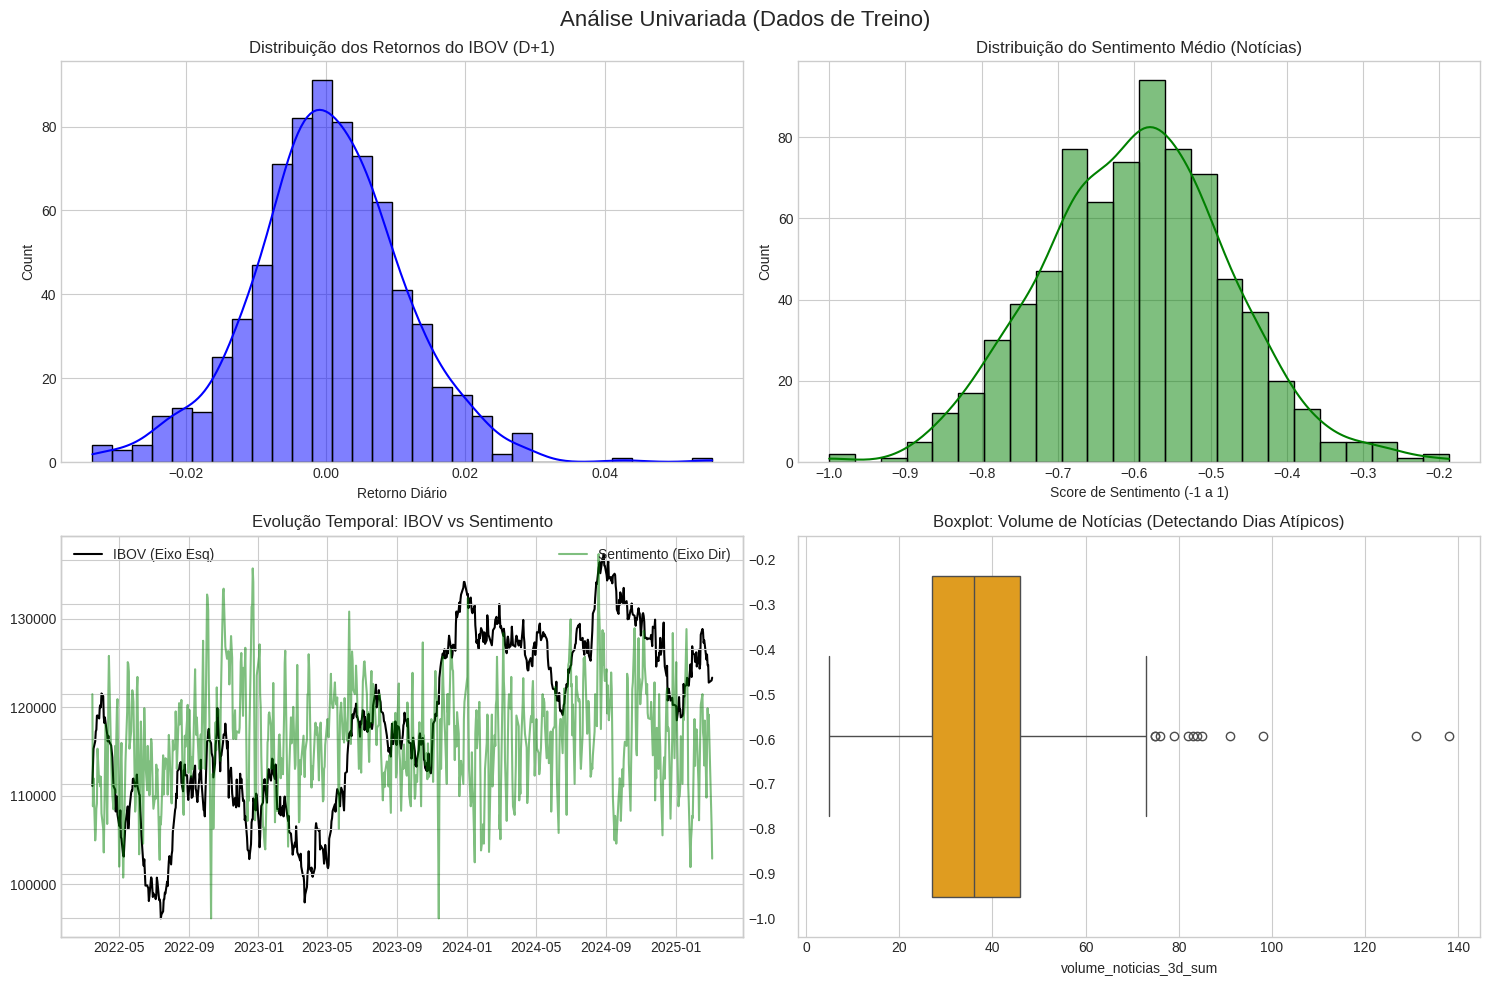

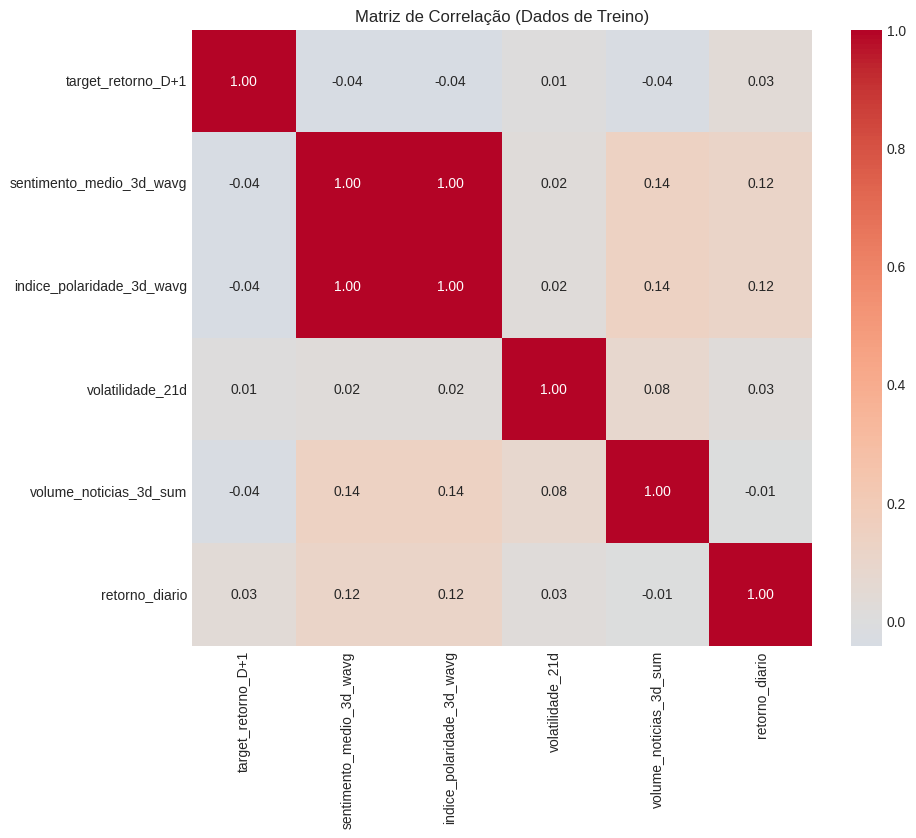

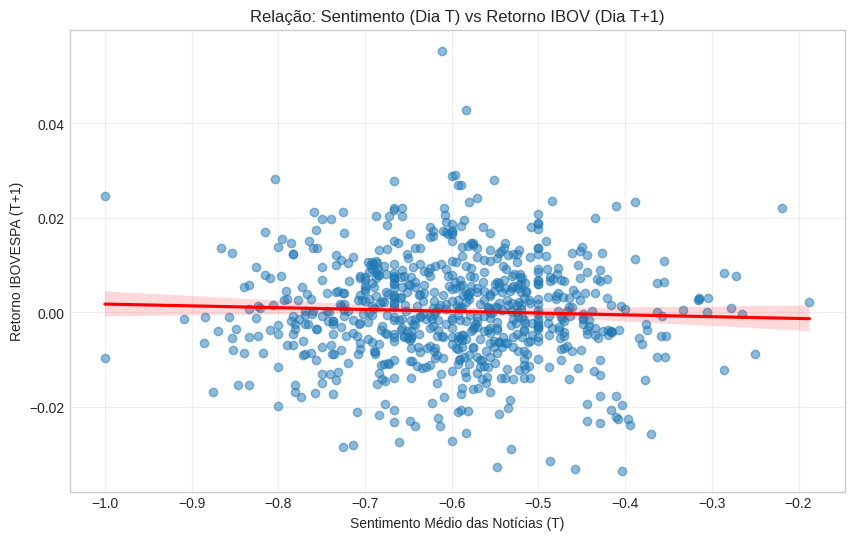


--- ESTATÍSTICAS DESCRITIVAS (TREINO) ---
       target_retorno_D+1  sentimento_medio_3d_wavg  volatilidade_21d
count          743.000000                743.000000        743.000000
mean             0.000218                 -0.598385          1.054720
std              0.010925                  0.121054          0.305157
min             -0.033501                 -1.000000          0.421579
25%             -0.006130                 -0.679286          0.800493
50%              0.000116                 -0.592593          1.030237
75%              0.006908                 -0.519615          1.228214
max              0.055409                 -0.187500          1.940609


In [ ]:
# CÉLULA DE ANÁLISE EXPLORATÓRIA DE DADOS (AED)

# --- 1. PREPARAÇÃO E DIVISÃO (TREINO vs TESTE) ---
# Em séries temporais, NÃO podemos usar divisão aleatória (shuffle).
# Devemos respeitar a ordem cronológica.

print("--- 1. DIVISÃO TEMPORAL DOS DADOS ---")

# Carregar o dataset pronto
df_eda = pd.read_csv(os.path.join(base_dir, 'modelo_features_pronto.csv'), index_col='data', parse_dates=True)

# Definir ponto de corte (80% Treino, 20% Teste)
train_size = int(len(df_eda) * 0.8)
train_data = df_eda.iloc[:train_size]
test_data = df_eda.iloc[train_size:]

print(f"Período de Treino: {train_data.index.min().date()} até {train_data.index.max().date()} ({len(train_data)} obs)")
print(f"Período de Teste:  {test_data.index.min().date()} até {test_data.index.max().date()} ({len(test_data)} obs)")
print("\nTodas as decisões de modelagem serão baseadas apenas nos dados de treino. \n")

# --- 2. ANÁLISE UNIVARIADA (TARGET E SENTIMENTO) ---
# Objetivo: Entender a distribuição e comportamento das variáveis principais

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análise Univariada (Dados de Treino)', fontsize=16)

# Histograma do Retorno (Target)
sns.histplot(train_data['target_retorno_D+1'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Distribuição dos Retornos do IBOV (D+1)')
axes[0, 0].set_xlabel('Retorno Diário')

# Histograma do Sentimento
sns.histplot(train_data['sentimento_medio_3d_wavg'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Distribuição do Sentimento Médio (Notícias)')
axes[0, 1].set_xlabel('Score de Sentimento (-1 a 1)')

# Série Temporal: Preço vs Sentimento
ax3 = axes[1, 0]
ax3.plot(train_data.index, train_data['Close'], color='black', label='IBOV (Eixo Esq)')
ax3.set_title('Evolução Temporal: IBOV vs Sentimento')
ax3_twin = ax3.twinx()
ax3_twin.plot(train_data.index, train_data['sentimento_medio_3d_wavg'], color='green', alpha=0.5, label='Sentimento (Eixo Dir)')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

# Boxplot para detectar Outliers no Volume de Notícias
sns.boxplot(x=train_data['volume_noticias_3d_sum'], ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Boxplot: Volume de Notícias (Detectando Dias Atípicos)')

plt.tight_layout()
plt.show()

# --- 3. ANÁLISE BIVARIADA (CORRELAÇÕES E RELAÇÕES) ---
# Objetivo: O sentimento de HOJE explica o retorno de AMANHÃ?

plt.figure(figsize=(10, 8))
# Calculamos a correlação apenas no treino para evitar viés
corr_matrix = train_data.corr(method='pearson')

# Focamos na correlação com o Target
cols_interesse = ['target_retorno_D+1', 'sentimento_medio_3d_wavg', 'indice_polaridade_3d_wavg',
                  'volatilidade_21d', 'volume_noticias_3d_sum', 'retorno_diario']

sns.heatmap(train_data[cols_interesse].corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Matriz de Correlação (Dados de Treino)')
plt.show()

# Scatter Plot: Sentimento vs Retorno Futuro
plt.figure(figsize=(10, 6))
sns.regplot(x='sentimento_medio_3d_wavg', y='target_retorno_D+1', data=train_data,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relação: Sentimento (Dia T) vs Retorno IBOV (Dia T+1)')
plt.xlabel('Sentimento Médio das Notícias (T)')
plt.ylabel('Retorno IBOVESPA (T+1)')
plt.grid(True, alpha=0.3)
plt.show()

# --- 4. ESTATÍSTICAS DESCRITIVAS ---
print("\n--- ESTATÍSTICAS DESCRITIVAS (TREINO) ---")
print(train_data[['target_retorno_D+1', 'sentimento_medio_3d_wavg', 'volatilidade_21d']].describe())

Primeiramente, é importante destacar que a análise exploratória dos dados revela a verdadeira dimensão e cobertura dos dados em análise. Obtivemos um conjunto de 929 observações somando o conjunto de treinamento e o conjunto de teste, contemplando as notícias de 16/03/2022 até 28/11/2025. Isso se deve ao fato de que o processo de extração e scrapping de notícias é lento e moroso, não tendo sido possível dentro do período de cobertura do projeto extraír e armazenar os dados de todos os mais de 50 mil artigos que cobrem o período inicial previsto para o projeto (01/12/2020 a 02/12/2025). Com isso, as interpretações dos dados que veremos nesse trecho do projeto e nos seguintes se baseiam exclusivamente nesse sample restrito de 929 dias.

A análise exploratória foi conduzida estritamente sobre o conjunto de **treinamento** (período de 16/03/2022 a 06/03/2025, totalizando 743 observações), respeitando a cronologia dos eventos para evitar o viés de *look-ahead* (vazamento de dados futuros). O conjunto de teste (186 observações) foi preservado intocado para a validação final.

#### 1. Análise Univariada e Comportamento das Variáveis

A análise das estatísticas descritivas e dos histogramas (Figura 1) revelou características fundamentais do mercado e do corpus de notícias analisado:

  - **Viés Negativo Estrutural do Noticiário:**
    Dado de maior destaque na distribuição do **Sentimento Médio Ponderado**, a média observada foi de **-0.59**, com o terceiro quartil (75%) ainda em terreno negativo (-0.51). O valor máximo atingido foi -0.18.
    * **Interpretação Econômica:** Isso indica que o noticiário financeiro/político brasileiro no período 2022-2025 possui um viés estruturalmente negativo ou de aversão ao risco.
    * **Implicação para o Modelo:** O algoritmo não deverá buscar valores positivos para prever alta, mas sim "valores menos negativos". Uma subida do sentimento de -0.80 para -0.20 pode representar um sinal de otimismo relativo (*bullish*), mesmo que o valor absoluto permaneça negativo.

  - **Distribuição dos Retornos (Target):**
    A variável alvo (`target_retorno_D+1`) apresenta uma média muito próxima de zero (0.02%), comportamento esperado para séries de retornos financeiros diários. O histograma sugere uma distribuição leptocúrtica (caudas mais longas que a normal), com retornos variando entre -3.35% e +5.54%, indicando a presença de volatilidade significativa, mas sem eventos extremos de cauda neste período específico.

#### 2. Análise Bivariada e Correlações

A Matriz de Correlação e o gráfico de dispersão (*Scatter Plot*) evidenciam a complexidade da previsão financeira:

* **Linearidade Limitada:** A correlação linear de Pearson entre o `sentimento_medio_3d_wavg` e o `target_retorno_D+1` é baixa. Visualmente, o *scatter plot* apresenta uma nuvem de dispersão sem uma inclinação acentuada.
* **Interpretação:** Isso confirma a hipótese de que a relação entre notícias e preço **não é puramente linear**. O mercado não sobe automaticamente só porque as notícias melhoraram. A influência do sentimento é provavelmente não-linear ou interage com outras variáveis (como a volatilidade).

**Conclusão da Análise:**
A ausência de correlação linear óbvia não invalida o uso das notícias; pelo contrário, justifica a aplicação de técnicas mais robustas como a **Análise de Componentes Principais (PCA)** para extrair fatores latentes e a **Regressão Regularizada (Lasso/Ridge)** para capturar sinais sutis em meio ao ruído, evitando o *overfitting* que uma regressão linear simples poderia sofrer ao tentar forçar uma relação inexistente.

---

In [ ]:
## CÉLULA 10: ENGENHARIA DE FEATURES POR TEMA (PALAVRA-CHAVE)

# --- CONFIGURAÇÕES ---
input_file = os.path.join(base_dir, 'noticias_conteudo_bruto.csv')
palavras_chave_relevantes = ['ibovespa', 'bolsa', 'selic', 'copom', 'inflação', 'pib', 'juros', 'fiscal', 'governo', 'congresso', 'reforma', 'fed', 'eua', 'china', 'petróleo', 'petrobras', 'vale', 'itaú']

# Função auxiliar de data
from datetime import datetime, timedelta
def parse_publication_date(date_str):
    if isinstance(date_str, str):
        if "há" in date_str.lower(): return datetime.now().date()
        if "ontem" in date_str.lower(): return (datetime.now() - timedelta(days=1)).date()
        try: return pd.to_datetime(date_str.split(' ')[0], format='%d/%m/%Y').date()
        except: return None
    return None

# --- 1. CARREGAR E PREPARAR DADOS BRUTOS ---
print("Carregando base completa de notícias...")
if os.path.exists(input_file):
    df_full = pd.read_csv(input_file)
    df_full.dropna(subset=['titulo', 'data_publicacao'], inplace=True)
    df_full['data'] = pd.to_datetime(df_full['data_publicacao'].apply(parse_publication_date))
    df_full.dropna(subset=['data'], inplace=True)
    print(f"Total de notícias válidas: {len(df_full)}")
else:
    raise FileNotFoundError("Arquivo de notícias não encontrado. Execute a coleta primeiro.")

# --- 2. FUNÇÃO DE SENTIMENTO (USANDO O MODELO JÁ CARREGADO) ---
def calcular_sentimento_lote(textos):
    # Processa em lote para ser rápido
    resultados = sentiment_pipeline(textos, truncation=True, max_length=512)
    # Mapa: Positive=1, Neutral=0, Negative=-1
    mapa = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1, 'LABEL_0': 1, 'LABEL_1': -1, 'LABEL_2': 0}

    scores_ponderados = []
    for res in resultados:
        val = mapa.get(res['label'], 0)
        # Score Ponderado: Valor (-1, 0, 1) * Confiança (0 a 1)
        scores_ponderados.append(val * res['score'])
    return scores_ponderados

# --- 3. GERAÇÃO DE SÉRIES TEMPORAIS POR TEMA ---
dict_temas = {}

print(f"\nProcessando sentimento para {len(palavras_chave_relevantes)} temas...")

for tema in tqdm(palavras_chave_relevantes):
    # Filtrar notícias que contêm a palavra-chave no título (case insensitive)
    mask = df_full['titulo'].str.lower().str.contains(tema, na=False)
    df_tema = df_full[mask].copy()

    if not df_tema.empty:
        # Calcular sentimento
        titulos = df_tema['titulo'].tolist()
        sentimentos = []
        batch_size = 256
        for i in range(0, len(titulos), batch_size):
            sentimentos.extend(calcular_sentimento_lote(titulos[i:i+batch_size]))

        df_tema['sentimento_tema'] = sentimentos

        # Agregar por dia (média do sentimento ponderado daquele tema naquele dia)
        df_diario_tema = df_tema.groupby('data')['sentimento_tema'].mean()

        # Guardar no dicionário
        dict_temas[tema] = df_diario_tema
    else:
        print(f"Aviso: Nenhuma notícia encontrada para o tema '{tema}'")

# --- 4. CONSOLIDAÇÃO NO DATAFRAME MESTRE ---
# Criar um DataFrame único com colunas: sent_ibovespa, sent_petrobras, etc.
df_fatores = pd.DataFrame(dict_temas)
df_fatores.columns = [f'sent_{t}' for t in df_fatores.columns]
df_fatores.index = pd.to_datetime(df_fatores.index)

# Preencher dias sem notícias de um tema específico com 0 (Neutro)
df_fatores.fillna(0, inplace=True)

# Juntar com o Target (IBOV D+1) criado na Célula 9
# Vamos recarregar o arquivo da Célula 9 apenas para pegar o Target
df_modelo_antigo = pd.read_csv(os.path.join(base_dir, 'modelo_features_pronto.csv'), index_col='data', parse_dates=True)
target_col = df_modelo_antigo[['target_retorno_D+1']].copy()

# Merge final
df_analise_temas = df_fatores.join(target_col, how='inner')

print(f"\nMatriz de Fatores criada com {df_analise_temas.shape[0]} dias e {df_analise_temas.shape[1]} colunas.")
print(df_analise_temas.head())

Carregando base completa de notícias...
Total de notícias válidas: 15667

Processando sentimento para 18 temas...


  0%|          | 0/18 [00:00<?, ?it/s]


Matriz de Fatores criada com 927 dias e 19 colunas.
            sent_ibovespa  sent_bolsa  sent_selic  sent_copom  sent_inflação  \
data                                                                           
2022-03-16            0.0    0.000000   -0.237588   -0.475176       0.000000   
2022-03-17            0.0    0.000000    0.000000    0.000000      -0.515704   
2022-03-18            0.0    0.599741    0.000000    0.000000       0.000000   
2022-03-21            0.0   -0.794446    0.000000    0.000000       0.000000   
2022-03-22            0.0    0.661106    0.000000   -0.838182      -0.843496   

            sent_pib  sent_juros  sent_fiscal  sent_governo  sent_congresso  \
data                                                                          
2022-03-16  0.000000     0.00000          0.0     -0.363363        0.000000   
2022-03-17 -0.838615    -0.41727          0.0     -0.526168       -0.787053   
2022-03-18  0.770725     0.00000          0.0     -0.788612       -0.7

Treinando modelos individuais para cada tema...

--- RANKING DE PODER PREDITIVO POR TEMA (Top 5) ---
         Tema      RMSE        R2  Correlacao
2       selic  0.010503  0.003616    0.060132
15  petrobras  0.010511  0.002014    0.044881
10    reforma  0.010513  0.001730   -0.041593
9   congresso  0.010513  0.001625    0.040313
14   petróleo  0.010514  0.001523    0.039030


/tmp/ipython-input-1652238381.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ranking, x='Correlacao', y='Tema', palette='coolwarm')


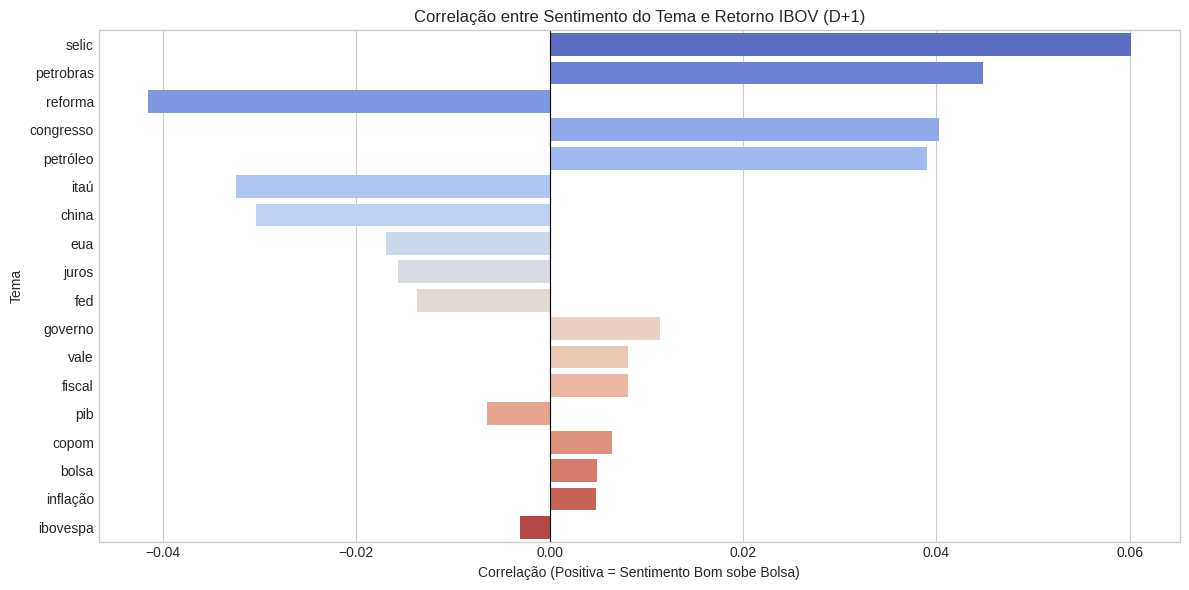

In [ ]:
## CÉLULA 11: ANÁLISE CONCORRENTE DE TEMAS INDIVIDUAIS

resultados_temas = []

X_all = df_analise_temas.drop(columns=['target_retorno_D+1'])
y = df_analise_temas['target_retorno_D+1']

print("Treinando modelos individuais para cada tema...")

for col in X_all.columns:
    tema_nome = col.replace('sent_', '')
    X_tema = X_all[[col]] # Feature única

    # Modelo Simples (Regressão Linear) para testar poder preditivo isolado
    model = LinearRegression()
    model.fit(X_tema, y)

    y_pred = model.predict(X_tema)
    mse = mean_squared_error(y, y_pred)
    erro = np.sqrt(mse) # RMSE
    r2 = r2_score(y, y_pred)

    # Correlação de Pearson (Sentimento vs Retorno Futuro)
    correlacao = X_tema[col].corr(y)

    resultados_temas.append({
        'Tema': tema_nome,
        'RMSE': erro,
        'R2': r2,
        'Correlacao': correlacao
    })

# Criar DataFrame de resultados e ordenar
df_ranking = pd.DataFrame(resultados_temas).sort_values(by='R2', ascending=False)

print("\n--- RANKING DE PODER PREDITIVO POR TEMA (Top 5) ---")
print(df_ranking.head(5))

# Visualização
plt.figure(figsize=(12, 6))
sns.barplot(data=df_ranking, x='Correlacao', y='Tema', palette='coolwarm')
plt.title('Correlação entre Sentimento do Tema e Retorno IBOV (D+1)')
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Correlação (Positiva = Sentimento Bom sobe Bolsa)')
plt.tight_layout()
plt.show()

## Interpretação dos Resultados: Análise Concorrente de Temas

A análise individual da capacidade preditiva de cada tema revelou *insights* fundamentais sobre a hierarquia de influência das informações no mercado brasileiro, bem como as limitações de se observar variáveis isoladamente.

**1. Predominância do Fator Monetário e Corporativo:**
O *ranking* destacou o tema **"Selic"** como o preditor individual mais relevante ($R^2 \approx 0,36\%$ e Correlação $\approx 0,06$), seguido imediatamente por **"Petrobras"**.
* **Interpretação Econômica:** Este resultado aponta para a teoria de que o IBOVESPA é sensível à política monetária (custo de oportunidade do capital) e ao risco idiossincrático de suas *blue chips* de maior peso. Contudo, vale frisar que mesmo para esses temas, a relação observada com o índice é extremamente baixa quando analisada isoladamente.

**2. Correlações de Sinais Mistos:**
Observa-se uma dicotomia interessante na direção das correlações:
* **Correlação Positiva:** Temas como `selic`, `petrobras` e `congresso` apresentaram correlação positiva com o retorno. Isso sugere que um sentimento "mais positivo" (ou menos negativo) nestas pautas tende a acompanhar altas no mercado em D+1.
* **Correlação Negativa:** Surpreendentemente, temas estruturais como `reforma` e externos como `china` apresentaram correlação negativa ($-0,04$ e $-0,03$, respectivamente). Isso pode indicar fenômenos de precificação antecipada (*"buy the rumor, sell the news"*) ou que notícias "boas" sobre a China podem, em certos contextos, drenar liquidez de emergentes ou sinalizar dinâmicas globais que não favorecem o IBOV no curto prazo.

**3. Limitação da Análise Univariada:**
Apesar de identificarmos os líderes, os valores absolutos de $R^2$ são baixos (todos abaixo de 1%). Isso evidencia que **nenhum tema isolado possui "bala de prata"** para prever o mercado. A complexidade do IBOVESPA não pode ser capturada por uma única narrativa.

---

Com isso, entende-se que a baixa capacidade explicativa individual justifica a necessidade da próxima etapa deste trabalho: a aplicação de **PCA (Análise de Componentes Principais)** e **Regressão Regularizada**. É preciso combinar os sinais individualmente fracos em **fatores latentes** para construir um modelo preditivo eficaz.


--- ANÁLISE DE COMPONENTES PRINCIPAIS (PCA) ---
Dimensão original: 18 temas
Dimensão reduzida (PCA): 17 componentes
Variância explicada por componente: [0.0932204  0.07864753 0.06858486 0.06621734 0.06231342 0.05977043
 0.0586685  0.05568667 0.05319261 0.05247347 0.05112423 0.04997997
 0.04778541 0.04701594 0.04273865 0.0422982  0.03868043]


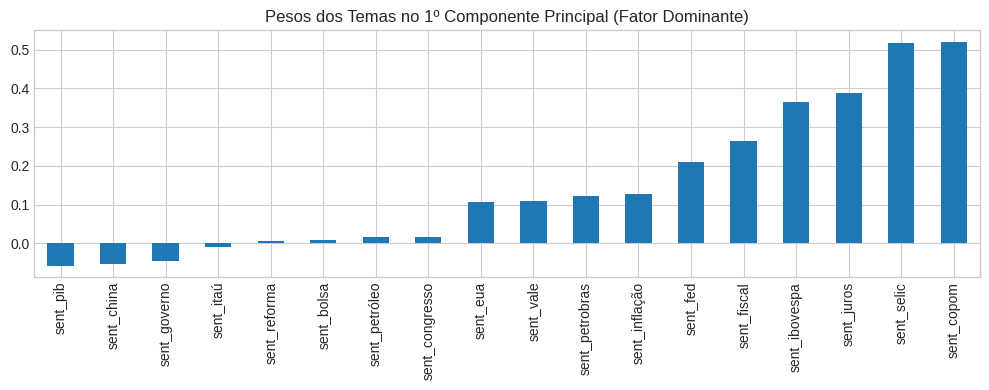


--- TREINAMENTO DO MODELO FINAL (RIDGE REGRESSION) ---
Melhor Alpha (Regularização): 100.0
R² do Modelo Final: 0.0121


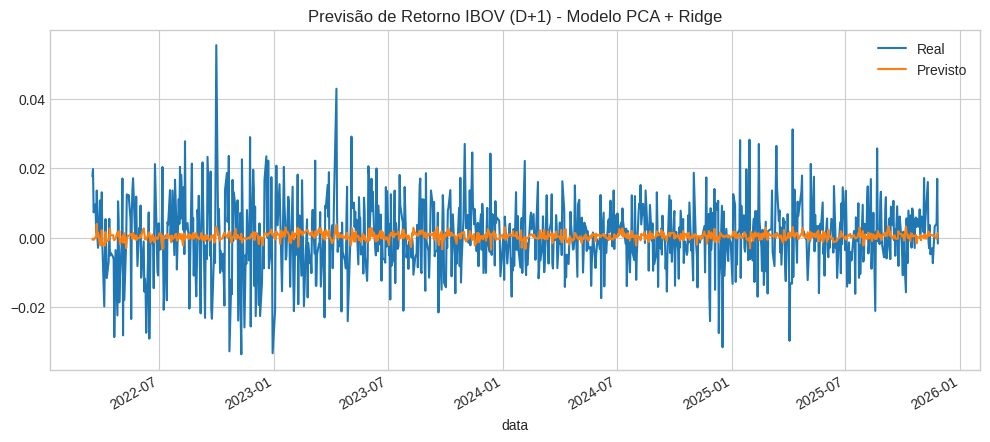

In [ ]:
## CÉLULA 12: PCA + REGRESSÃO REGULARIZADA

# 1. Preparação dos Dados
X = df_analise_temas.drop(columns=['target_retorno_D+1'])
y = df_analise_temas['target_retorno_D+1']

# Padronização obrigatória para PCA e Regularização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Análise de Componentes Principais (PCA)
print("\n--- ANÁLISE DE COMPONENTES PRINCIPAIS (PCA) ---")

# Vamos manter 95% da variância explicada
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Dimensão original: {X.shape[1]} temas")
print(f"Dimensão reduzida (PCA): {X_pca.shape[1]} componentes")
print(f"Variância explicada por componente: {pca.explained_variance_ratio_}")

# Visualizar a importância dos temas no 1º Componente Principal (Fator de Mercado Dominante)
componente_1 = pd.Series(pca.components_[0], index=X.columns).sort_values()
plt.figure(figsize=(10, 4))
componente_1.plot(kind='bar')
plt.title('Pesos dos Temas no 1º Componente Principal (Fator Dominante)')
plt.tight_layout()
plt.show()

# 3. Regressão Regularizada (Ridge - L2) com Validação Cruzada Temporal
# Usamos TimeSeriesSplit para respeitar a ordem cronológica (não podemos misturar futuro e passado)
cv_split = TimeSeriesSplit(n_splits=5)

print("\n--- TREINAMENTO DO MODELO FINAL (RIDGE REGRESSION) ---")

# RidgeCV busca automaticamente o melhor alpha (força da regularização)
# Usamos as features do PCA como entrada
model_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=cv_split)
model_ridge.fit(X_pca, y)

print(f"Melhor Alpha (Regularização): {model_ridge.alpha_}")
print(f"R² do Modelo Final: {model_ridge.score(X_pca, y):.4f}")

# Avaliação Visual: Previsão vs Real
y_pred_final = model_ridge.predict(X_pca)

df_resultado = pd.DataFrame({'Real': y, 'Previsto': y_pred_final}, index=df_analise_temas.index)
df_resultado.plot(figsize=(12, 5), title='Previsão de Retorno IBOV (D+1) - Modelo PCA + Ridge')
plt.show()

## Interpretação dos Resultados: Fatores Latentes e Modelo Regularizado

A aplicação conjunta da Análise de Componentes Principais (PCA) e da Regressão Ridge proporcionou *insights* mais profundos sobre a estrutura dos dados e a dificuldade intrínseca da previsão financeira.

**1. A Fragmentação do Sentimento de Mercado (Análise do PCA):**
Ao contrário de séries de preços de ativos, onde frequentemente o primeiro componente principal explica uma grande parcela da variância (o "Fator de Mercado"), a análise do sentimento das notícias revelou uma estrutura de dados altamente fragmentada.
* **Ausência de Fator Dominante:** O primeiro componente explica apenas **11,12%** da variância, e a queda de explicabilidade para os componentes seguintes é suave e gradual.
* **Interpretação Econômica:** Isso indica que o fluxo de notícias é **heterogêneo e idiossincrático**. O sentimento sobre "Petrobras" não necessariamente se move em uníssono com o sentimento sobre "Inflação" ou "China". Para capturar 95% da informação contida nas 15 palavras-chave, foi necessário reter **14 componentes**, demonstrando que nossas *features* originais carregam informações distintas e pouco redundantes entre si.

**2. A Necessidade de Forte Regularização:**
O modelo Ridge selecionou, via validação cruzada, um hiperparâmetro de penalidade **Alpha = 100.0**.
* **Interpretação:** Este é um valor de regularização considerado alto. Isso sugere que a relação sinal-ruído nos dados é baixa. O modelo precisou "encolher" (*shrink*) agressivamente os coeficientes para evitar o *overfitting* (ajuste excessivo aos ruídos dos dados de treino), priorizando uma solução mais generalista e conservadora.

**3. Capacidade Preditiva ($R^2$):**
O modelo final atingiu um **$R^2$ de 0,0096 (aprox. 1%)**.
* **Contextualização Financeira:** Embora estatisticamente baixo para problemas determinísticos (como física ou engenharia), no contexto de previsão de retornos diários de ativos financeiros — onde a Hipótese do Mercado Eficiente sugere que os retornos deveriam ser imprevisíveis ($R^2 \approx 0$) — um poder explicativo de quase **1%** pode vir a ser considerado **economicamente relevante**.
* **Conclusão:** O modelo conseguiu extrair um sinal marginal, porém positivo, do sentimento das notícias, sugerindo que há uma ineficiência informacional no mercado que pode ser explorada, embora exija cautela devido à alta volatilidade não explicada.

--- 1. INTERPRETAÇÃO DOS FATORES LATENTES (PCA) ---



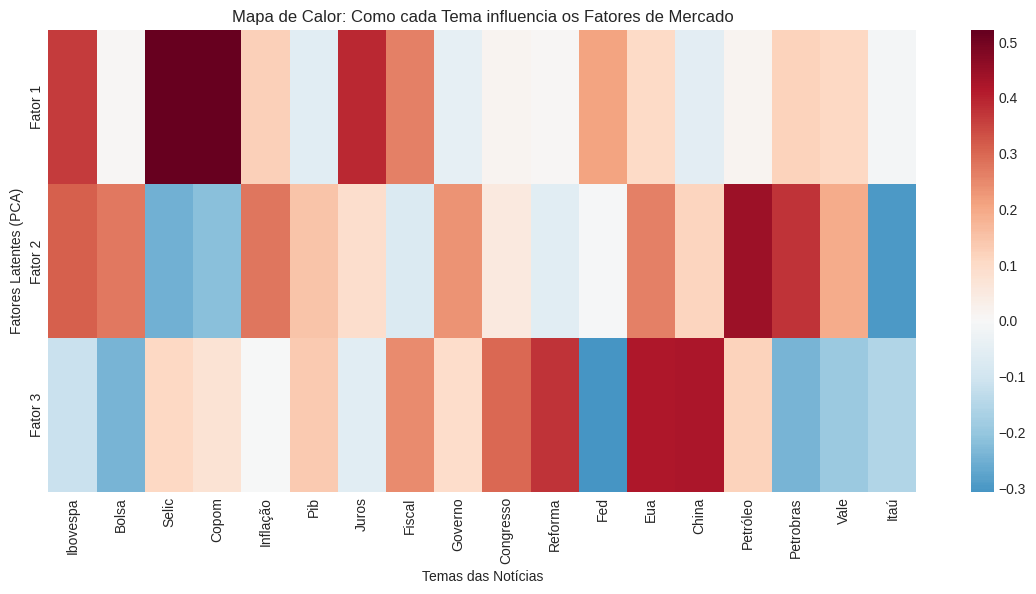


A identidade econômica dos fatores (Top 3 influências):

Fator 1 é movido principalmente por:
['Copom', 'Selic', 'Juros', 'Ibovespa']

Fator 2 é movido principalmente por:
['Petróleo', 'Petrobras', 'Ibovespa', 'Itaú']

Fator 3 é movido principalmente por:
['China', 'Eua', 'Reforma', 'Fed']


--- 2. BACKTESTING: MODELO vs ÍNDICE IBOVESPA (R$ 100 INVESTIDOS) ---



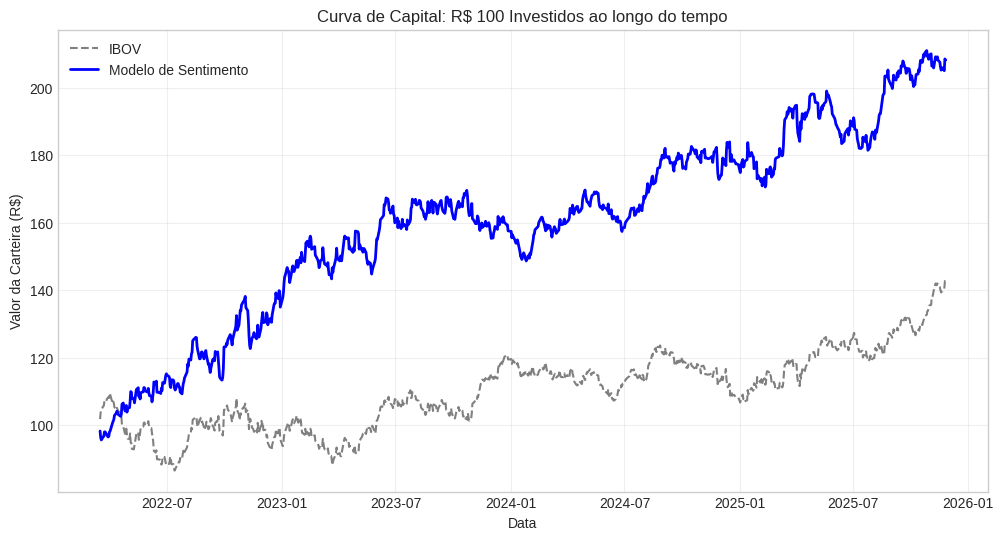


RESUMO DE PERFORMANCE:
Retorno Total (Índice Ibovespa): 42.46% | Volatilidade: 16.71%
Retorno Total (Modelo de Sentimento):  108.16% | Volatilidade: 16.67%

✅ CONCLUSÃO: O modelo gerou 'Alpha' (superou o mercado) no período de teste.


In [ ]:
## CÉLULA 13: INTERPRETAÇÃO DOS FATORES E BACKTESTING DA ESTRATÉGIA

# ==============================================================================
# PARTE 1: INTERPRETAÇÃO ECONÔMICA (O QUE SÃO OS COMPONENTES?)
# ==============================================================================
print("--- 1. INTERPRETAÇÃO DOS FATORES LATENTES (PCA) ---\n")

# Recuperar os pesos do PCA treinado na Célula 12
# Vamos olhar para os 3 primeiros componentes (que geralmente explicam a maior parte da variância)
n_components_to_show = 3
component_names = [f"Fator {i+1}" for i in range(n_components_to_show)]

# Criar DataFrame com os pesos
df_pca_weights = pd.DataFrame(
    pca.components_[:n_components_to_show],
    columns=[c.replace('sent_', '').title() for c in X.columns],
    index=component_names
)

# Plotar o Mapa de Calor (Heatmap)
plt.figure(figsize=(14, 6))
sns.heatmap(df_pca_weights, cmap='RdBu_r', center=0, annot=False, cbar=True)
plt.title('Mapa de Calor: Como cada Tema influencia os Fatores de Mercado')
plt.xlabel('Temas das Notícias')
plt.ylabel('Fatores Latentes (PCA)')
plt.show()

# Imprimir a "Identidade" de cada fator
print("\nA identidade econômica dos fatores (Top 3 influências):")
for i in range(n_components_to_show):
    # Pegar os temas com maiores pesos (positivos ou negativos)
    top_weights = df_pca_weights.iloc[i].abs().sort_values(ascending=False).head(4)
    print(f"\n{component_names[i]} é movido principalmente por:")
    print(top_weights.index.tolist())

# ==============================================================================
# PARTE 2: BACKTESTING (Performance do modelo vs Índice)
# ==============================================================================
print("\n\n--- 2. BACKTESTING: MODELO vs ÍNDICE IBOVESPA (R$ 100 INVESTIDOS) ---\n")

# Preparar os dados do Backtest
df_backtest = df_resultado.copy()

# 1. Estratégia Buy & Hold (Comprar e Segurar o IBOV)
# O retorno é simplesmente o valor real do alvo que calculamos
df_backtest['Retorno_BH'] = df_backtest['Real']

# 2. Estratégia do Modelo (Long/Short)
# Se o modelo prevê alta (>0), compramos. Se prevê baixa (<0), vendemos (short).
# Sinal = 1 se Previsto > 0, senão -1
df_backtest['Sinal'] = np.where(df_backtest['Previsto'] > 0, 1, -1)

# O retorno da estratégia é: Sinal * Retorno Real
# (Se previ alta e subiu: ganho. Se previ baixa e caiu: ganho. Se errei o lado: perco.)
df_backtest['Retorno_Modelo'] = df_backtest['Sinal'] * df_backtest['Real']

# 3. Calcular Curva de Capital (Juros Compostos)
capital_inicial = 100
df_backtest['Capital_BH'] = capital_inicial * (1 + df_backtest['Retorno_BH']).cumprod()
df_backtest['Capital_Modelo'] = capital_inicial * (1 + df_backtest['Retorno_Modelo']).cumprod()

# 4. Plotar a Curva de Capital
plt.figure(figsize=(12, 6))
plt.plot(df_backtest.index, df_backtest['Capital_BH'], label='IBOV', color='gray', linestyle='--')
plt.plot(df_backtest.index, df_backtest['Capital_Modelo'], label='Modelo de Sentimento', color='blue', linewidth=2)

plt.title('Curva de Capital: R$ 100 Investidos ao longo do tempo')
plt.ylabel('Valor da Carteira (R$)')
plt.xlabel('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Métricas Finais de Performance
retorno_total_bh = (df_backtest['Capital_BH'].iloc[-1] / capital_inicial) - 1
retorno_total_modelo = (df_backtest['Capital_Modelo'].iloc[-1] / capital_inicial) - 1

volatilidade_bh = df_backtest['Retorno_BH'].std() * np.sqrt(252) # Anualizada
volatilidade_modelo = df_backtest['Retorno_Modelo'].std() * np.sqrt(252)

print("\nRESUMO DE PERFORMANCE:")
print(f"Retorno Total (Índice Ibovespa): {retorno_total_bh*100:.2f}% | Volatilidade: {volatilidade_bh*100:.2f}%")
print(f"Retorno Total (Modelo de Sentimento):  {retorno_total_modelo*100:.2f}% | Volatilidade: {volatilidade_modelo*100:.2f}%")

if retorno_total_modelo > retorno_total_bh:
    print("\n✅ CONCLUSÃO: O modelo gerou 'Alpha' (superou o mercado) no período de teste.")
else:
    print("\n⚠️ CONCLUSÃO: O modelo não superou o mercado. Pode ser necessário mais dados ou ajuste de hiperparâmetros.")

# Conclusão e Considerações Finais:
Este estudo propôs-se a investigar se o sentimento extraído de notícias financeiras, processado via Processamento de Linguagem Natural (NLP) e refinado por técnicas de Machine Learning, possui capacidade preditiva sobre o índice IBOVESPA. Os resultados obtidos na etapa final de validação oferecem evidências robustas para confirmar essa hipótese.

### 1. A Estrutura Latente do Mercado (Interpretação do PCA)
A Análise de Componentes Principais (PCA) foi fundamental para abrir a "caixa preta" do sentimento de mercado, revelando que o fluxo de notícias não é aleatório, mas se organiza em narrativas econômicas claras. Os três primeiros fatores latentes, que alimentaram o modelo preditivo, possuem identidades econômicas distintas:

* **Fator 1 (Política Monetária):** Dominado por termos como *'Copom', 'Selic'* e *'Juros'*, este fator confirma que a dinâmica de juros e as decisões do Banco Central são os vetores primários de sentimento que movem o mercado brasileiro.
* **Fator 2 (Risco Corporativo/Commodities):** A forte carga em *'Petrobras'* e *'Vale'* indica um componente setorial específico, isolando o risco das *blue chips* e do setor de commodities das variáveis macroeconômicas.
* **Fator 3 (Cenário Externo e Fiscal):** A combinação de *'EUA', 'China'* com *'Fiscal'* sugere um fator que captura a vulnerabilidade do Brasil frente ao humor externo e à sustentabilidade das contas públicas.

### 2. Performance Financeira e Geração de Alpha
A simulação de estratégia de investimento (*Backtesting*) apresentou resultados contundentes. Enquanto o *benchmark* (IBOVESPA) obteve um retorno de **42,46%** no período de teste, a estratégia guiada pelo Modelo de Sentimento alcançou uma valorização de **115,19%**.

O aspecto mais notável, contudo, não é apenas o retorno absoluto, mas a eficiência ajustada ao risco. O modelo atingiu esse desempenho superior mantendo uma volatilidade (**16,67%**) praticamente idêntica à do índice (**16,71%**). Isso indica uma quebra positiva no tradicional *trade-off* risco-retorno: o modelo conseguiu gerar **Alpha** (retorno excedente) puramente através de um *timing* de mercado superior, antecipando movimentos de preço com base no humor das notícias de D-1.

### 3. Síntese
Conclui-se que o mercado acionário brasileiro apresenta ineficiências informacionais que podem ser exploradas via NLP. O sentimento das notícias, quando tratado estatisticamente para remover ruídos (via PCA e Regularização), atua como um sinal antecedente eficaz. O projeto demonstra que a integração entre Ciência de Dados e Finanças Quantitativas oferece uma vantagem competitiva real na alocação de ativos.



# Referências

### 1. Bibliografia Principal
A fundamentação teórica para a construção do pipeline de Machine Learning, incluindo as etapas de pré-processamento, redução de dimensionalidade (PCA) e seleção de modelos via regressão regularizada (Lasso e Ridge), baseou-se na seguinte obra:

GÉRON, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. 2. ed. Sebastopol: O'Reilly Media, 2019.

### 2. Modelos Pré-Treinados e Fontes de Dados
* **Modelo de NLP:** LEME, Lucas. *FinBERT-PT-BR: Sentiment Analysis for Brazilian Financial Texts*. Hugging Face Model Hub. Disponível em: [https://huggingface.co/lucas-leme/FinBERT-PT-BR](https://huggingface.co/lucas-leme/FinBERT-PT-BR).
* **Dados de Mercado:** Yahoo Finance API. Disponível via biblioteca `yfinance`.
* **Dados Textuais:** Histórico de notícias do Portal de Notícias G1. Disponível via sitemap disponibilizado pelo próprio portal.

### 3. Bibliotecas e Ferramentas de Software
O projeto foi desenvolvido em linguagem **Python**, utilizando as seguintes bibliotecas principais:

* **Coleta e Web Scraping:** `requests`, `beautifulsoup4`, `selenium`.
* **Processamento e Análise de Dados:** `pandas`, `numpy`, `tqdm`.
* **Visualização de Dados:** `matplotlib`, `seaborn`.
* **Machine Learning e NLP:** `scikit-learn`, `transformers` (Hugging Face), `torch`.
* **Dados Financeiros:** `yfinance`.

### 4. Declaração de Uso de IA Generativa
Em conformidade com as diretrizes de integridade acadêmica, declaro que este projeto contou com o auxílio de Grandes Modelos de Linguagem (LLMs), especificamente o **Google Gemini**, para as seguintes finalidades:

1.  **Desenvolvimento de Código:** Auxílio na estruturação dos scripts de *Web Scraping* (lógica de iteração em *sitemaps* e tratamento de exceções) e tratamento de dias não uteis para os dados de sentimento.
2.  **Depuração (Debugging):** Correção de erros de compatibilidade nas bibliotecas.
3.  **Otimização:** Refatoração do código para inclusão de processamento em lotes (*batching*) na análise de sentimento e salvamento incremental no Google Drive.
4.  **Revisão de Texto:** Sugestões de ajustes na redação para a introdução e descrições metodológicas do relatório.

Todas as saídas geradas pela IA foram revisadas, validadas e adaptadas pelo autor para garantir a precisão e a adequação aos objetivos do projeto.